In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyteomics.mztab
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, \
    balanced_accuracy_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

In [2]:
classes = pd.read_csv('filenames.csv', names=['filename', 'class'])
classes['filename'] = (classes['filename'].str.split('.')
                       .apply(lambda x: x[0]))
classes = classes.set_index('filename')

In [3]:
psms, sequences = dict(), set()
mztab_dir = '../data/processed'
for filename in os.listdir(mztab_dir):
    file_key = filename.split('.')[0]
    if file_key in classes.index:
        psms[file_key] = (pyteomics.mztab.MzTab(os.path.join(mztab_dir,
                                                             filename))
                          .spectrum_match_table[['sequence', 'charge',
                                                 'exp_mass_to_charge',
                                                 'calc_mass_to_charge']])
        sequences.update(psms[file_key]['sequence'])

In [4]:
features = pd.DataFrame(0, index=psms.keys(), columns=sequences)

In [5]:
for file_key, psm in psms.items():
    spectral_counts = psm.groupby('sequence').size()
    features.loc[file_key, spectral_counts.index] += spectral_counts

In [6]:
# # Remove low-abundant features.
# min_count = 100
# features[features.le(min_count)] = np.nan

In [7]:
features = features.dropna('columns', 'all').fillna(0).astype(int)

In [8]:
clss = np.asarray(classes.reindex(features.index)['class'] == 'A', np.uint8)

In [9]:
n_trees = 1000
classifier = RandomForestClassifier(
    n_trees, n_jobs=-1, random_state=42, class_weight='balanced_subsample')

# Evaluate the model in a cross-validation setting.
n_splits = 10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2,
                             random_state=42)
accuracies = np.empty(n_splits, np.float32)
average_precisions = np.empty(n_splits, np.float32)
roc_aucs = np.empty(n_splits, np.float32)
interval = np.linspace(0, 1, 101, dtype=np.float32)
tprs = np.empty((n_splits, 101), np.float32)
tprs_train = np.empty((n_splits, 101), np.float32)
precisions = np.empty((n_splits, 101), np.float32)
feature_importances = np.empty((n_splits, len(features.columns.values)),
                               np.float32)
for i, (train_index, test_index) in enumerate(sss.split(features.values,
                                                        clss)):
    features_train, features_test = (features.values[train_index],
                                     features.values[test_index])
    clss_train, clss_test = clss[train_index], clss[test_index]
    classifier_sss = clone(classifier)
    classifier_sss.fit(features_train, clss_train)
    clss_pred = classifier_sss.predict_proba(features_test)[:, 1]
    # Simple evaluation metrics.
    accuracies[i] = balanced_accuracy_score(
            clss_test, np.asarray(clss_pred > 0.5, np.int))
    average_precisions[i] = average_precision_score(clss_test, clss_pred)
    roc_aucs[i] = roc_auc_score(clss_test, clss_pred)
    # Evaluation curves.
    fpr, tpr, _ = roc_curve(clss_test, clss_pred)
    tprs[i:, ] = np.interp(interval, fpr, tpr)
    fpr_train, tpr_train, _ = roc_curve(
        clss_train, classifier_sss.predict_proba(features_train)[:, 1])
    tprs_train[i:, ] = np.interp(interval, fpr_train, tpr_train)
    precision, recall, _ = precision_recall_curve(clss_test, clss_pred)
    precisions[i:, ] = np.interp(interval, recall[::-1], precision[::-1])
    # Feature importances.
    feature_importances[i:, ] = classifier_sss.feature_importances_

stats = {'accuracy': np.mean(accuracies),
         'accuracy_std': np.std(accuracies),
         'average_precision': np.mean(average_precisions),
         'average_precision_std': np.std(average_precisions),
         'roc_auc': np.mean(roc_aucs),
         'roc_auc_std': np.std(roc_aucs),
         'tpr_mean': np.mean(tprs, axis=0),
         'tpr_std': np.std(tprs, axis=0),
         'tpr_train_mean': np.mean(tprs_train, axis=0),
         'tpr_train_std': np.std(tprs_train, axis=0),
         'precision_mean': np.mean(precisions, axis=0),
         'precision_std': np.std(precisions, axis=0),
         'feature_importances': np.mean(feature_importances, axis=0),
         'feature_importances_std': np.std(feature_importances, axis=0)}

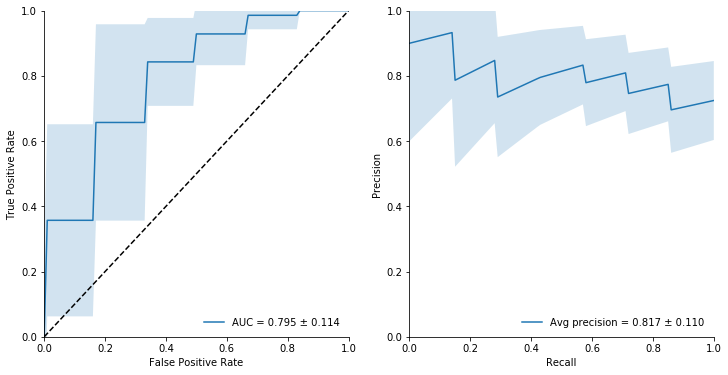

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
tpr = stats['tpr_mean']
tpr[0], tpr[-1] = 0, 1
tpr_train = stats['tpr_train_mean']
tpr_train[0], tpr_train[-1] = 0, 1
interval = np.linspace(0, 1, 101)
ax.plot(interval, tpr,
        label=f'AUC = {stats["roc_auc"]:.3f} ± {stats["roc_auc_std"]:.3f}')
ax.fill_between(interval, tpr - stats['tpr_std'], tpr + stats['tpr_std'],
                alpha=0.2)
        
ax.plot([0, 1], [0, 1], c='black', ls='--')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend(loc='lower right', frameon=False)
        
ax = axes[1]
precision = stats['precision_mean']
ax.plot(interval, precision,
        label=f'Avg precision = {stats["average_precision"]:.3f} ± '
              f'{stats["average_precision_std"]:.3f}')
ax.fill_between(interval, precision - stats['precision_std'],
                precision + stats['precision_std'], alpha=0.2)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

ax.legend(loc='lower right', frameon=False)


sns.despine()

plt.show()
plt.close()

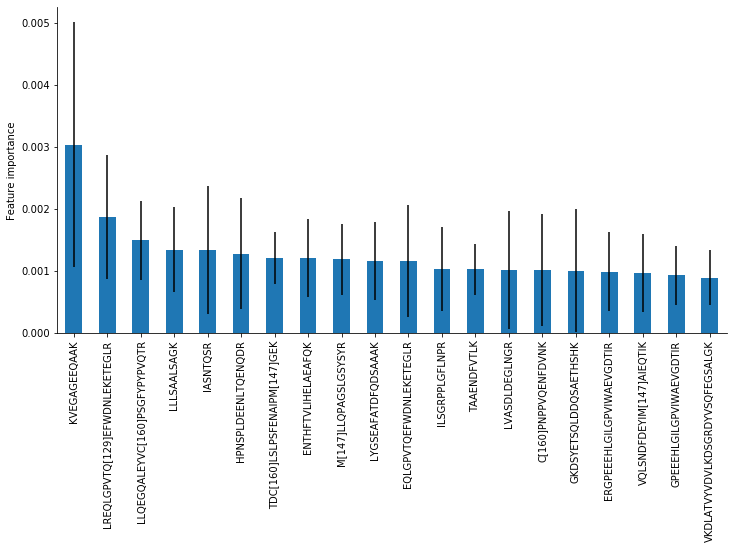

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

feature_importances = pd.DataFrame(
    {'feature_importance': stats['feature_importances'],
     'std': stats['feature_importances_std']},
    index=features.columns.values)
feature_importances = feature_importances.sort_values(
    'feature_importance', ascending=False).head(20)
feature_importances['feature_importance'].plot.bar(
    yerr=feature_importances['std'], legend=False, ax=ax)

ax.set_ylim(0, ax.get_ylim()[1])

ax.set_ylabel('Feature importance')

sns.despine()

plt.show()
plt.close()